In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import pickle
import scipy.stats
from tqdm import tqdm_notebook
from sklearn.decomposition import IncrementalPCA 
from helpers.data_generator import process_data
import seaborn as sns

Using TensorFlow backend.


In [2]:
%matplotlib inline
font={'family': 'Times New Roman',
      'size': 10}
plt.rc('font', **font)
matplotlib.rcParams['figure.facecolor'] = (1,1,1,1)

In [3]:
data_path_base = '/scratch/gpfs/jabbate/mixed_data/final_data_batch_'
rawdata = {}
foo = [68]
for i in foo:
    with open(data_path_base + str(i) + '.pkl','rb') as f:
        rawdata.update(pickle.load(f, encoding='latin1'))
len(rawdata.keys())

50

In [4]:
keys = list(rawdata[list(rawdata.keys())[0]].keys())
keys.sort()
keys

['C_coil_139',
 'C_coil_19',
 'C_coil_199',
 'C_coil_259',
 'C_coil_319',
 'C_coil_79',
 'C_coil_method',
 'C_coil_nonstandard_139',
 'C_coil_nonstandard_199',
 'C_coil_nonstandard_79',
 'F_coil_1a',
 'F_coil_1b',
 'F_coil_2a',
 'F_coil_2b',
 'F_coil_3a',
 'F_coil_3b',
 'F_coil_4a',
 'F_coil_4b',
 'F_coil_5a',
 'F_coil_5b',
 'F_coil_6a',
 'F_coil_6b',
 'F_coil_7a',
 'F_coil_7b',
 'F_coil_8a',
 'F_coil_8b',
 'F_coil_9a',
 'F_coil_9b',
 'I_coil_150L',
 'I_coil_150U',
 'I_coil_210L',
 'I_coil_210U',
 'I_coil_270L',
 'I_coil_270U',
 'I_coil_30L',
 'I_coil_30U',
 'I_coil_330L',
 'I_coil_330U',
 'I_coil_90L',
 'I_coil_90U',
 'I_coil_method',
 'I_coil_nonstandard_150',
 'I_coil_nonstandard_30',
 'I_coil_nonstandard_90',
 'a_EFIT01',
 'a_EFIT02',
 'a_EFITRT1',
 'a_EFITRT2',
 'beam_feedback_power_target_quantity',
 'beam_feedback_power_target_value',
 'beam_feedback_switch',
 'beam_feedback_torque_target_quantity',
 'beam_feedback_torque_target_value',
 'beam_target_power',
 'beam_target_torque

In [5]:
actuator_names = ['pinj','tinj','curr','gasA']
profile_names = ['temp','dens','press_EFIT02','rotation','ffprime_EFIT02','q_EFIT02']
sig_names = actuator_names + profile_names
normalization_method = 'RobustScaler'
lookbacks = {}
actuator_lookback = 6
for sig in actuator_names:
    lookbacks[sig] = actuator_lookback
for sig in profile_names:
    lookbacks[sig] = 1
lookahead = 3
sample_step=1
window_overlap=0
window_length=1
uniform_normalization=True
data, valdata, normalization_params = process_data(rawdata, sig_names, normalization_method, window_length,
                                                    window_overlap, lookbacks, lookahead, sample_step,
                                                    uniform_normalization, train_frac=0.8, val_frac=0.2,
                                                    nshots=12000,verbose=1, flattop_only=True)

Gathering:   0%|          | 0/39 [00:00<?, ?it/s]

Signals: curr, dens, ffprime_EFIT02, gasA, pinj, press_EFIT02, q_EFIT02, rotation, temp, tinj
Number of useable shots:  39
Number of shots used:  39
Total number of timesteps:  10657


/home/wconlin/plasma-profile-predictor/helpers/data_generator.py:308: RuntimeWarning: Mean of empty slice
  return np.nanmean(array[start:start+window_length], axis=0)
Removing ECH:   0%|          | 0/3373 [00:00<?, ?it/s]

Shots with Complete NaN: 
6896 samples total


Removing weird gas:  13%|#2        | 124/986 [00:00<00:00, 1236.72it/s]

Removed 3784 samples
3112 samples remaining


Splitting: 100%|##########| 19/19 [00:00<00:00, 3673.79it/s]

Removed 1278 samples
1834 samples remaining
1834 samples remaining after pruning
Total number of samples:  1834
Number of training samples:  1467
Number of validation samples:  367


In [6]:
# split into I/O pairs
X = {sig: data[sig][:,0,:].T for sig in profile_names}
Y = {sig: data[sig][:,-1,:].T for sig in profile_names}
U = {sig: data[sig].T for sig in actuator_names}

Xval = {sig: valdata[sig][:,0,:].T for sig in profile_names}
Yval = {sig: valdata[sig][:,-1,:].T for sig in profile_names}
Uval = {sig: valdata[sig].T for sig in actuator_names}

In [7]:
# take SVD of inputs
params = {}
for sig in tqdm_notebook(X.keys(), position=0):
    U1,S,V = np.linalg.svd(X[sig], full_matrices=False)
    params[sig + '_U'] = U1
    params[sig + '_S'] = S
    params[sig + '_V'] = V
    params[sig + '_percentile'] = np.cumsum(S)/np.sum(S)

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


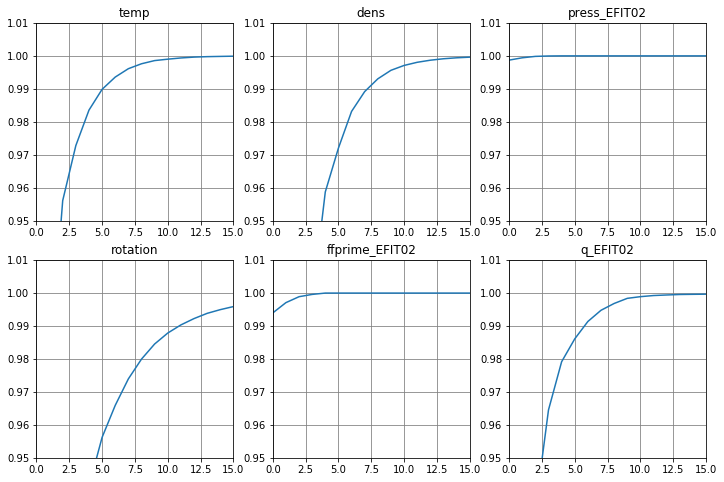

In [9]:
nrows = 2
ncols = 3
figsize = (ncols*4,nrows*4)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
for i, sig in tqdm_notebook(enumerate(profile_names)):
    ax = axes[np.unravel_index(i,(nrows,ncols))]
    ax.plot(params[sig+'_percentile'])
    ax.title.set_text(sig)
    ax.set_ylim([.95,1.01])
    ax.set_xlim([0,15])
    ax.yaxis.grid(color='gray')
    ax.xaxis.grid(color='gray')

In [10]:
# extract PCA modes
kernels= {}
pca_modes = {}
nmodes = {}
var_cutoff = .99
for sig in profile_names:
    nmodes[sig] = np.nonzero(params[sig + '_percentile']>var_cutoff)[0][1]
    pca_modes[sig] = params[sig + '_U'][:,0:nmodes[sig]].T
    kernels[sig] = np.matmul(pca_modes[sig],pca_modes[sig].T)

In [11]:
# form input/output matrices of PCA modes
Xpca = np.concatenate([np.matmul(np.diag(params[sig + '_S']),
                                 params[sig + '_V'])[0:nmodes[sig],:] for sig in profile_names],axis=0)
Ypca = np.concatenate([np.matmul(pca_modes[sig],Y[sig]) for sig in profile_names],axis=0)
Upca = np.concatenate([U[sig] for sig in actuator_names],axis=0)

In [12]:
# pinvert input matrix
XU = np.concatenate([Xpca,Upca],axis=0)
XUinv = np.linalg.pinv(XU)

Text(0.5, 1, 'B')

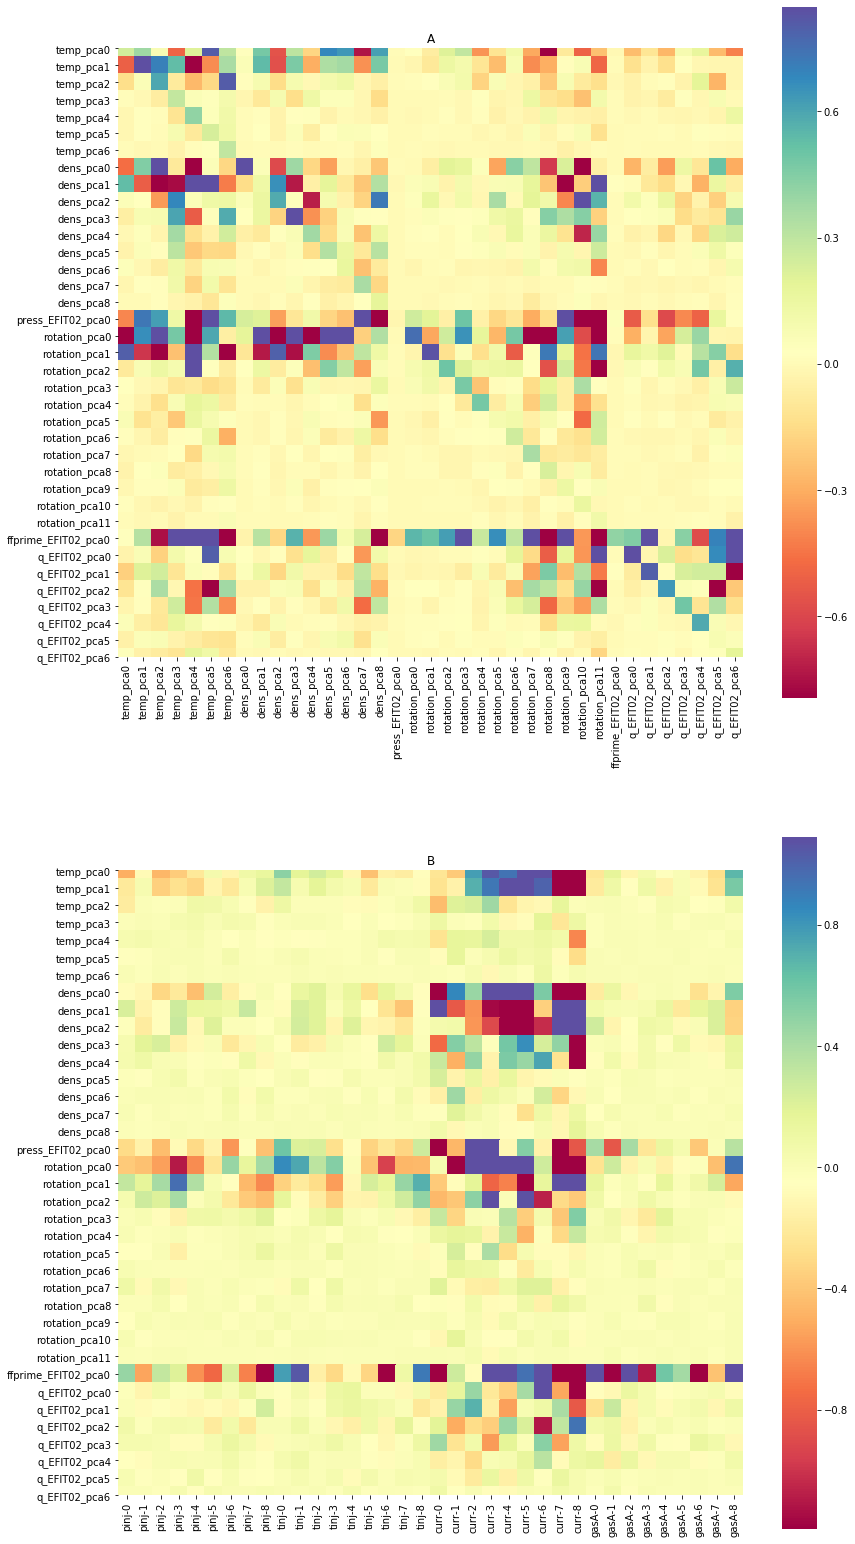

In [13]:
# get A,B matrices
AB = np.matmul(Ypca,XUinv)
A = AB[:,0:Xpca.shape[0]]
B = AB[:,Xpca.shape[0]:]
f, axes = plt.subplots(2, 1, figsize=(14, 28))
Aylabel = [sig + '_pca' + str(i) for sig in profile_names for i in range(nmodes[sig]) ]
Axlabel = Aylabel
Bylabel = Aylabel
Bxlabel = [sig + '-' + str(i) for sig in actuator_names for i in range(actuator_lookback + lookahead) ]
cmap='Spectral'
sns.heatmap(A, cmap=cmap, annot=False, square=True, robust=True, 
            xticklabels = Axlabel, yticklabels = Aylabel, ax=axes[0]).set_title('A')
sns.heatmap(B, cmap=cmap, annot=False, square=True, robust=True, 
            xticklabels = Bxlabel, yticklabels = Bylabel, ax=axes[1]).set_title('B')


In [1]:
A

NameError: name 'A' is not defined

In [14]:
class linear_model():
    def __init__(self,A,B,pca_modes,profile_names,actuator_names):
        self.A = A
        self.B = B
        self.pca_modes = pca_modes
        self.profile_names = profile_names
        self.actuator_names = actuator_names
        self.which_modes = {}
        i=0
        for sig in self.profile_names:
            self.which_modes[sig] = np.arange(i,i+self.pca_modes[sig].shape[0])
            i = self.which_modes[sig][-1]+1
            
    def predict_on_batch(self,inputs=None, X=None, U=None):
        if inputs is not None and X is None and U is None:
            xinput = np.concatenate([np.matmul(self.pca_modes[sig],inputs[sig]) for sig in self.profile_names])
            uinput = np.concatenate([inputs[sig] for sig in self.actuator_names])
        elif inputs is not None and X is not None and U is None:
            xinput = np.concatenate([np.matmul(self.pca_modes[sig],inputs[sig]) for sig in self.profile_names])
            uinput = np.concatenate([X[sig] for sig in self.actuator_names])
        elif inputs is None and X is not None and U is not None:
            xinput = np.concatenate([np.matmul(self.pca_modes[sig],X[sig]) for sig in self.profile_names])
            uinput = np.concatenate([U[sig] for sig in self.actuator_names])
        else:
            raise ValueError("Must provide either input dictionary or seperate X and U inputs")
        youtput = np.matmul(self.A,xinput) + np.matmul(self.B,uinput)
        prediction = {sig: np.matmul(self.pca_modes[sig].T,youtput[self.which_modes[sig]])
                       for i, sig in enumerate(self.profile_names)}
        return prediction

In [15]:
model = linear_model(A,B,pca_modes,profile_names,actuator_names)
predictions = model.predict_on_batch(X,U)
preds_noinput = model.predict_on_batch(X,{key:val+.5 for key,val in U.items()})

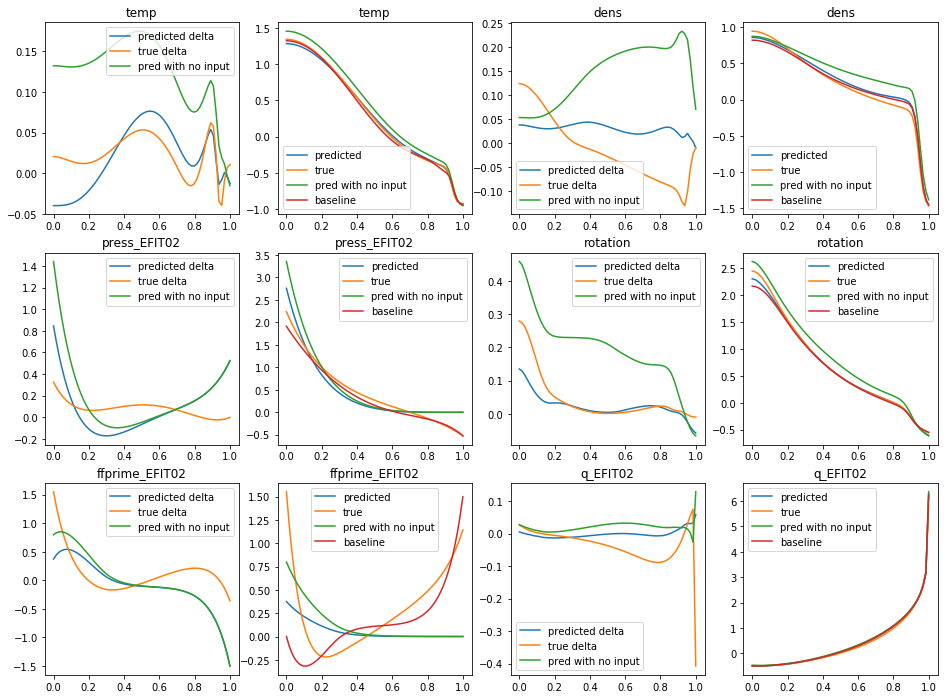

In [17]:
# test: get a set of inputs, predict output, and project back onto PCA
idx = 150
baseline = {sig: X[sig][:,idx] for sig in profile_names}
true = {sig: Y[sig][:,idx] for sig in profile_names}
prediction = {sig: predictions[sig][:,idx] for sig in profile_names}
pred_noinput = {sig: preds_noinput[sig][:,idx] for sig in profile_names}

#plot
psi = np.linspace(0,1,65)
figsize = (4*4,3*4)
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=figsize)
for i, sig in tqdm_notebook(enumerate(profile_names)):
        ax[np.unravel_index(2*i,(3,4))].plot(psi,prediction[sig]-baseline[sig],
                                             psi,true[sig]-baseline[sig],psi,pred_noinput[sig]-baseline[sig])
        ax[np.unravel_index(2*i,(3,4))].title.set_text(sig)
        ax[np.unravel_index(2*i,(3,4))].legend(['predicted delta','true delta','pred with no input'])
        ax[np.unravel_index(2*i+1,(3,4))].plot(psi,prediction[sig],psi,true[sig],
                                               psi,pred_noinput[sig],psi, baseline[sig])
        ax[np.unravel_index(2*i+1,(3,4))].title.set_text(sig)
        ax[np.unravel_index(2*i+1,(3,4))].legend(['predicted','true','pred with no input','baseline'])

In [ ]:
plt.plot(params['press_EFIT02_U'][:,0:5])

In [ ]:
plt.plot(X['press_EFIT02'][:,10:15])